# Phase 4 Project: Skin Condition Classification
## Technical Modeling Notebook
### Authored by Trinity Gahagen
---
---

This notebook and the analysis notebook both work with the Skin Condition image dataset found on this [Kaggle page](https://www.kaggle.com/datasets/syedalinaqvi/augmented-skin-conditions-image-dataset).


This notebook will focus on tackling the task of classification of the images in this dataset.

## Table of Contents
- [Summary of Analysis Notebook](#summary)
- [Dataset Overview](#dataset-overview)
- [Basic Imports](#basic-imports)
- [Classical ML Approach](#classical-ml-approach)
    - [Preprocessing Functions and Testing](#preprocessing-functions-and-testing)
- [Convolutional Neural Network Approach: Custom Architecture](#convolutional-neural-network-approach-custom-architecture)
- [External Resources](#external-resources)

<a id="summary"></a>
# Summary of Analysis Notebook
---
From the analysis notebook, the results we found are as follows:

- There are 399 images in each category of skin conditions available: Acne, Carcinoma, Eczema, Keratosis, Milia, and Rosacea, totalling 2394 images.

- The average red channel intensity of images typically appears greater than the blue and green channel intensities. This is reasonable, since the images are largely depicting skin, which contains more red tones than others.

- The average blue channel intensities for an individual image range from about 95-111.

- The average green channel intensities for an individual image in each category range from about 100-135.

- The average red channel intensities for an individual image in each category range from about 131-172.

- There is a lot of variable resolutions for images in each category; Rosacea has the smallest range of resolutions while Carcinoma has the largest.

These findings may have some impact on the approaches that we will perform in this notebook, particularly with how much resizing will affect the heuristic features that the models can learn.

 <a id="dataset-overview"></a>
# Dataset Overview
---

The following description of the dataset was taken from the Kaggle page.

>**Description**:
>
>This dataset contains augmented images of six different dermatological conditions. Each category includes 399 images, providing a balanced >dataset ideal for training machine learning models, particularly in the field of medical image analysis.
>
>**Categories**:
>
>Acne: A common skin condition that occurs when hair follicles become clogged with oil and dead skin cells, leading to pimples, blackheads, or whiteheads.
>
>Carcinoma: A type of skin cancer that begins in the basal or squamous cells. The images in this category may show various stages and forms of skin carcinoma.
>
>Eczema: A condition that makes the skin red, inflamed, itchy, and sometimes results in blisters. The images depict different manifestations of eczema.
>
>Keratosis: A skin condition characterized by rough, scaly patches on the skin caused by excessive growth of keratin. This category includes images of various types of keratosis, such as actinic keratosis.
>
>Milia: Small, white, benign bumps that typically appear on the face, especially around the eyes and on the cheeks. The images show different instances of this condition.
>
>Rosacea: A chronic skin condition that causes redness and visible blood vessels in your face. This category contains images depicting the typical characteristics of rosacea.
>
>
>**Dataset Details**:
>
>Total Images: 2,394
>
>Images per Category: 399
>
>Image Format: JPEG
>
>Image Size: Variable.
>
>Augmentation Techniques: The images have been augmented using techniques such as rotation, flipping, zooming, and brightness adjustment to enhance the diversity of the dataset and improve model generalization.

According to the Kaggle page, the dataset has already been augmented for the purpose of improving model generalization (helping to reduce overfitting). This will be kept in mind when using different machine learning approaches.

 <a id="basic-imports"></a>
# Basic Imports
---

In [2]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from glob import glob

# Plotting Tools
import colorcet as cc
from matplotlib.ticker import FuncFormatter

# Classical ML Models and Tools
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

# HOG tools
from skimage.feature import hog
from skimage import exposure

# Neural Network Models and Tools
from tensorflow.data import AUTOTUNE
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data.experimental import cardinality
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential as SequentialLayer
from tensorflow.keras import Input

In [3]:
# Directory of the data
PARENT_DIRECTORY = "../Skin_Conditions/"

<a id="classical-ml-approach"></a>
# Classical ML Approach
---

Before attempting an approach at tackling the classification of these images using deep learning, we will use classical machine learning techniques mixed with a technique utilized for object detection: Histogram of Oriented Gradients, or HOG.

The Histogram of Oriented Gradients (HOG) algorithm computes the distribution of gradient orientations in localized portions of an image (Tam, 2024). It divides an image into multiple subunits called windows, which are subdivided into blocks, and blocks are subdivided into cells. HOG calculator each cell’s pixel-wise gradient magnitude and orientation, then creates a histogram of those gradients. Histograms that are within the same block are then concatenated. These histograms are constructed with bins that represent the “angle” of the gradient (from 0-180), capturing both change in intensity of a pixel and the direction as well. All histograms are then concatenated into one giant vector and then visualized to show the shape of an object.

<a id="preprocessing-functions-and-testing"></a>
## Preprocessing Functions and Testing

In [49]:
# Create a functions to assist in importing data
def preprocess_image(image_path, r_height=200, r_width=200):
    """
    Opens an image using the image path, converts to grayscale, and resizes to the given pixel height and width
    Returns transformed image
    """

    # Read in image and convert to grayscale
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize to send into HOG feature extraction
    final_img = cv2.resize(gray, (r_width, r_height), interpolation=cv2.INTER_LINEAR)

    return final_img


def get_hog_features(image, orientations=9, ppc=(10, 10), cpb=(2,2), vis=True, norm_strat='L2-Hys'):
    """
    Performs HOG on a singular image passed in
    Returns the associated feature vector (and optionally the HOG image) as a list
    """

    # Perform HOG feature extraction on images
    return_list = hog(image=image,
                      orientations=orientations,
                      pixels_per_cell=ppc,
                      cells_per_block=cpb,
                      visualize=vis,
                      block_norm=norm_strat,
                      feature_vector=True)

    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

In [67]:
# Test out HOG function to see if it works
test_image = preprocess_image(os.path.join(PARENT_DIRECTORY, 'Acne/Acne_1.jpg'), r_height=200, r_width=200)

fd, hog_image = get_hog_features(test_image, orientations=8, vis=True, ppc=(10, 10))

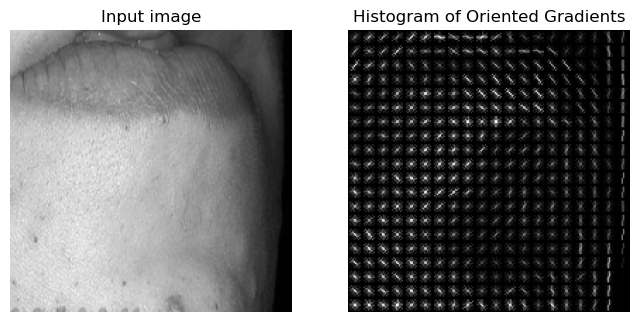

In [68]:
# Plot the input image and the HOG image for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(test_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [69]:
# Check the dimensions of the processed image and the length of the HOG feature vector
print(test_image.shape)
print(len(fd))

(200, 200)
11552


Both functions apppear to work correctly; now it's time to create a dataset of HOG features and their labels in order to create, train, and test a machine learning classifier.

In [7]:
# Create a list of subdirectories and corresponding labels for the purpose of creating a tabular dataset
subdirectories = [os.path.join(PARENT_DIRECTORY, d) for d in os.listdir(PARENT_DIRECTORY) if os.path.isdir(os.path.join(PARENT_DIRECTORY, d))]
class_labels = [d for d in os.listdir(PARENT_DIRECTORY) if os.path.isdir(os.path.join(PARENT_DIRECTORY, d))]
display(subdirectories)
display(class_labels)

['../Skin_Conditions/Acne',
 '../Skin_Conditions/Carcinoma',
 '../Skin_Conditions/Eczema',
 '../Skin_Conditions/Keratosis',
 '../Skin_Conditions/Milia',
 '../Skin_Conditions/Rosacea']

['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']

In [8]:
try:
    hog_feature_dataset = pd.read_csv('hog_feature_dataset.csv')
except:
    # Create lists for feature data and labels
    X = []
    y = []
    
    # Loop through subdirectories
    for n in range(len(subdirectories)):
        image_paths = os.listdir(subdirectories[n])
        label = class_labels[n]

        # Loop through every image path in each subdirectory and preprocess
        for image_name in image_paths:
            image = preprocess_image(os.path.join(subdirectories[n], image_name), r_height=200, r_width=200)
            features, _ = get_hog_features(image, orientations=8, vis=True, ppc=(10, 10))

            # Append features and corresponding labels to lists
            X.append(features)
            y.append(label)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Convert to dataframe and export
    hog_feature_dataset = pd.DataFrame(X)
    hog_feature_dataset['label'] = pd.Series(y)
    hog_feature_dataset.to_csv('hog_feature_dataset.csv')

In [9]:
# Checking that the dataset was created correctly
hog_feature_dataset.shape

(2394, 11554)

In [11]:
hog_feature_dataset.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,11543,11544,11545,11546,11547,11548,11549,11550,11551,label
0,0,0.211348,0.166950,0.237940,0.119206,0.158945,0.091624,0.074846,0.111099,0.237940,...,0.197499,0.047109,0.000000,0.004759,0.000000,0.013460,0.000000,0.000000,0.000000,Acne
1,1,0.208728,0.114609,0.092877,0.119227,0.220190,0.053851,0.173592,0.178275,0.220190,...,0.081708,0.240606,0.086694,0.170505,0.193546,0.240606,0.033096,0.137859,0.071150,Acne
2,2,0.264206,0.089693,0.148965,0.005641,0.123901,0.053102,0.258255,0.264206,0.189894,...,0.144737,0.238052,0.020689,0.125748,0.091612,0.238052,0.224589,0.238052,0.238052,Acne
3,3,0.246354,0.108047,0.137881,0.125360,0.103154,0.096391,0.155473,0.246354,0.246354,...,0.200697,0.247021,0.089394,0.246352,0.000000,0.199447,0.031855,0.200203,0.074420,Acne
4,4,0.051676,0.125630,0.152512,0.221810,0.277385,0.043925,0.105411,0.013363,0.146065,...,0.062598,0.163810,0.073421,0.085935,0.130334,0.282411,0.211685,0.086246,0.027026,Acne


In [14]:
# Create training/testing data
le = LabelEncoder()
X = hog_feature_dataset.drop(columns=['label'])
y = le.fit_transform(hog_feature_dataset['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size= 0.8,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)


In the following code blocks, we will be conducting a "shotgun" machine learning approach, where several classifiers will be used and evaluated to see which one performs best. The best performant models will be taken and hypertuned further.

In [123]:
# Create dictionary of models and corresponding metrics
shotgun_approach = {
    'knn' : {
        'model' : KNeighborsClassifier(),
        'score' : []
    },
    'svc' : {
        'model' : SVC(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingClassifier(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestClassifier(),
        'score' : []
    }
}

# Loop through and evaluate each model using a classification report
for model in shotgun_approach:
    classifier = shotgun_approach[model]['model']

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    class_report = classification_report(y_test, y_pred)
    shotgun_approach[model]['score'].append(class_report)

In [137]:
# Save the output of this cell so that we don't need to re-run the previous cell
%%capture output

for model in shotgun_approach:
    print(f'Model Name: {model}')
    print('Classification Report:')
    print(shotgun_approach[model]["score"][0])
    print('----------------------------------------')

with open('shotgun_approach_output.txt', 'w') as file:
    file.write(output.stdout)

In [141]:
output.show()

Model Name: knn
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.68      0.39        79
           1       0.29      0.39      0.33        80
           2       0.32      0.30      0.31        80
           3       0.55      0.20      0.29        80
           4       0.42      0.35      0.38        80
           5       0.86      0.07      0.14        80

    accuracy                           0.33       479
   macro avg       0.45      0.33      0.31       479
weighted avg       0.45      0.33      0.31       479

----------------------------------------
Model Name: svc
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.62      0.55        79
           1       0.53      0.69      0.60        80
           2       0.63      0.56      0.60        80
           3       0.57      0.53      0.55        80
           4       0.60      0.53      0.56        80
           5 

From the results above, unsurprisingly, the ensemble models performed the best. We will attempt to optimize these models, firstly by applying PCA to the dataset, to try and reduce the curse of dimensionality.

In [142]:
# Same approach, but this time with only the ensemble-learning methods along with PCA in a Pipeline
shotgun_approach_pca = {
    'gboost' : {
        'model' : GradientBoostingClassifier(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestClassifier(),
        'score' : []
    }
}


for model in shotgun_approach_pca:
    classifier = shotgun_approach_pca[model]['model']
    pipeline = Pipeline(steps=[('pca', PCA(n_components=0.95)), ('classifier', classifier)])
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    class_report = classification_report(y_test, y_pred)
    shotgun_approach_pca[model]['score'].append(class_report)

In [144]:
for model in shotgun_approach_pca:
    print(f'Model Name: {model}')
    print('Classification Report:')
    print(shotgun_approach_pca[model]["score"][0])
    print('----------------------------------------')

Model Name: gboost
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.61      0.46        79
           1       0.53      0.61      0.57        80
           2       0.62      0.50      0.55        80
           3       0.54      0.47      0.50        80
           4       0.56      0.44      0.49        80
           5       0.64      0.46      0.54        80

    accuracy                           0.52       479
   macro avg       0.54      0.52      0.52       479
weighted avg       0.54      0.52      0.52       479

----------------------------------------
Model Name: rand_forest
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.75      0.44        79
           1       0.49      0.51      0.50        80
           2       0.62      0.38      0.47        80
           3       0.52      0.36      0.43        80
           4       0.64      0.47      0.55        80
  

In [16]:
# Let's try one more classifier, without PCA
nbc = GaussianNB()

nbc.fit(X_train, y_train)

y_pred = nbc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.66      0.55        79
           1       0.33      0.55      0.41        80
           2       0.46      0.47      0.47        80
           3       0.43      0.28      0.34        80
           4       0.57      0.35      0.43        80
           5       0.60      0.39      0.47        80

    accuracy                           0.45       479
   macro avg       0.48      0.45      0.44       479
weighted avg       0.48      0.45      0.44       479



PCA seemed to dramatically decrease the performance of both models. It may be worth investigating different HOG hyperparameters to see if changing the data itself will lead to an increase in performance.

In [70]:
# Try different HOG feature hyperparameters on smaller batches of data to see the difference in performance
def small_batch_dataset(resize_shape=(200, 200), orientations=8, ppc=(10, 10), cpb=(2, 2), norm_strat='L2-Hys'):
    """
    Uses the same method of creating a HOG dataset from before, but with only 50 images instead of the whole dataset
    Creates DataFrame using different hyperparameter configurations passed in
    Returns smaller HOG DataFrame
    """

    X = []
    y = []

    for n in range(len(subdirectories)):
        image_paths = os.listdir(subdirectories[n])[:50]
        label = class_labels[n]

        for image_name in image_paths:
            image = preprocess_image(os.path.join(subdirectories[n], image_name), r_height=resize_shape[1], r_width=resize_shape[0])
            features, _ = get_hog_features(image, orientations=orientations, vis=True, ppc=ppc, cpb=cpb, norm_strat=norm_strat)
            X.append(features)
            y.append(label)

    X = np.array(X)
    y = np.array(y)

    batch_df = pd.DataFrame(X)
    batch_df['label'] = pd.Series(y)

    return batch_df

In [71]:
def hog_hyperparameter_test(df):
    """
    Creates a GradientBoostingClassifier model and trains/tests it on the hyperparameterized HOG dataset
    Returns the classification report results of the model
    """
    X = df.drop(columns=['label'])
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        train_size=0.8,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        stratify=y)

    model = GradientBoostingClassifier()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return classification_report(y_test, y_pred)


**TESTING HYPERPARAMETERS: BASELINE**
- Image shape: (200, 200)
- Number of Orientations: 8
- Pixels per cell: (10, 10)
- Cells per block: (2, 2)
- Normalization strategy: L2-Hys

In [24]:
# Establish a baseline model to compare different configurations to
# Uses default parameters that were defined earlier
df = small_batch_dataset()
results = hog_hyperparameter_test(df)

print(results)

              precision    recall  f1-score   support

        Acne       0.22      0.20      0.21        10
   Carcinoma       0.00      0.00      0.00        10
      Eczema       0.83      0.50      0.62        10
   Keratosis       0.33      0.40      0.36        10
       Milia       0.50      0.50      0.50        10
     Rosacea       0.29      0.40      0.33        10

    accuracy                           0.33        60
   macro avg       0.36      0.33      0.34        60
weighted avg       0.36      0.33      0.34        60



In [25]:
df.shape

(300, 11553)

**TESTING HYPERPARAMETERS**
- Image shape: (100, 100)
- Number of Orientations: 8
- Pixels per cell: (5, 5)
- Cells per block: (2, 2)
- Normalization strategy: L2-Hys

In [26]:
df = small_batch_dataset(resize_shape=(100, 100), orientations=8, ppc=(5,5))
results = hog_hyperparameter_test(df)

print(results)

              precision    recall  f1-score   support

        Acne       0.20      0.20      0.20        10
   Carcinoma       0.08      0.10      0.09        10
      Eczema       0.25      0.40      0.31        10
   Keratosis       0.00      0.00      0.00        10
       Milia       0.20      0.20      0.20        10
     Rosacea       0.22      0.20      0.21        10

    accuracy                           0.18        60
   macro avg       0.16      0.18      0.17        60
weighted avg       0.16      0.18      0.17        60



**TESTING HYPERPARAMETERS**
- Image shape: (250, 250)
- Number of Orientations: 9
- Pixels per cell: (10, 10)
- Cells per block: (2, 2)
- Normalization strategy: L1

In [72]:
df = small_batch_dataset(resize_shape=(250, 250), orientations=9, ppc=(10,10), norm_strat='L1')
results = hog_hyperparameter_test(df)

print(results)

              precision    recall  f1-score   support

        Acne       0.27      0.30      0.29        10
   Carcinoma       0.22      0.20      0.21        10
      Eczema       0.70      0.70      0.70        10
   Keratosis       0.44      0.40      0.42        10
       Milia       0.56      0.50      0.53        10
     Rosacea       0.33      0.40      0.36        10

    accuracy                           0.42        60
   macro avg       0.42      0.42      0.42        60
weighted avg       0.42      0.42      0.42        60



**TESTING HYPERPARAMETERS**
- Image shape: (64, 128)
- Number of Orientations: 9
- Pixels per cell: (8, 8)
- Cells per block: (2, 2)
- Normalization strategy: L2-Hys

In [73]:
df = small_batch_dataset(resize_shape=(64, 128), orientations=9, ppc=(8,8), norm_strat='L2-Hys')
results = hog_hyperparameter_test(df)

print(results)

              precision    recall  f1-score   support

        Acne       0.42      0.50      0.45        10
   Carcinoma       0.43      0.30      0.35        10
      Eczema       0.31      0.50      0.38        10
   Keratosis       0.50      0.40      0.44        10
       Milia       0.62      0.50      0.56        10
     Rosacea       0.33      0.30      0.32        10

    accuracy                           0.42        60
   macro avg       0.44      0.42      0.42        60
weighted avg       0.44      0.42      0.42        60



**TESTING HYPERPARAMETERS**
- Image shape: (64, 128)
- Number of Orientations: 8
- Pixels per cell: (8, 8)
- Cells per block: (2, 2)
- Normalization strategy: L1

In [74]:
df = small_batch_dataset(resize_shape=(64, 128), orientations=8, ppc=(8,8), norm_strat='L1')
results = hog_hyperparameter_test(df)

print(results)

              precision    recall  f1-score   support

        Acne       0.40      0.20      0.27        10
   Carcinoma       0.07      0.10      0.08        10
      Eczema       0.44      0.40      0.42        10
   Keratosis       0.10      0.10      0.10        10
       Milia       0.45      0.50      0.48        10
     Rosacea       0.36      0.40      0.38        10

    accuracy                           0.28        60
   macro avg       0.31      0.28      0.29        60
weighted avg       0.31      0.28      0.29        60



**TESTING HYPERPARAMETERS**
- Image shape: (64, 128)
- Number of Orientations: 9
- Pixels per cell: (8, 8)
- Cells per block: (2, 2)
- Normalization strategy: L2

In [75]:
df = small_batch_dataset(resize_shape=(64, 128), orientations=9, ppc=(8,8), norm_strat='L2')
results = hog_hyperparameter_test(df)

print(results)

              precision    recall  f1-score   support

        Acne       0.46      0.60      0.52        10
   Carcinoma       0.25      0.20      0.22        10
      Eczema       0.06      0.10      0.08        10
   Keratosis       0.57      0.40      0.47        10
       Milia       0.33      0.40      0.36        10
     Rosacea       0.25      0.10      0.14        10

    accuracy                           0.30        60
   macro avg       0.32      0.30      0.30        60
weighted avg       0.32      0.30      0.30        60



In [76]:
df = small_batch_dataset(resize_shape=(128, 64), orientations=9, ppc=(8,8), norm_strat='L2-Hys')
results = hog_hyperparameter_test(df)

print(results)

              precision    recall  f1-score   support

        Acne       0.25      0.20      0.22        10
   Carcinoma       0.18      0.20      0.19        10
      Eczema       0.12      0.10      0.11        10
   Keratosis       0.75      0.60      0.67        10
       Milia       0.14      0.10      0.12        10
     Rosacea       0.33      0.60      0.43        10

    accuracy                           0.30        60
   macro avg       0.30      0.30      0.29        60
weighted avg       0.30      0.30      0.29        60



The data configuration that makes the classifier perform the best appears to be the standard hyperparameter values of:
- Image shape: (64, 128)
- Number of Orientations: 9
- Pixels per cell: (8, 8)
- Cells per block: (2, 2)
- Normalization strategy: L2-Hys

This configuration produced a 9% accuracy increase from the baseline, and had the most balanced F1 scores for each class.

Knowing this, we will now create a dataset configured to these values, tune the hyperparameters of the classifier itself, and see how high of an accuracy we can get.

In [77]:
try:
    hog_feature_dataset = pd.read_csv('optimal_hog_feature_dataset.csv')
except:
    X = []
    y = []

    for n in range(len(subdirectories)):
        image_paths = os.listdir(subdirectories[n])
        label = class_labels[n]

        for image_name in image_paths:
            image = preprocess_image(os.path.join(subdirectories[n], image_name), r_width=64, r_height=128)
            features, _ = get_hog_features(image, orientations=9, vis=True, ppc=(8, 8), norm_strat='L2-Hys')
            X.append(features)
            y.append(label)
    
    X = np.array(X)
    y = np.array(y)

    hog_feature_dataset = pd.DataFrame(X)
    hog_feature_dataset['label'] = pd.Series(y)
    hog_feature_dataset.to_csv('optimal_hog_feature_dataset.csv')

In [78]:
hog_feature_dataset.shape

(2394, 3781)

In [80]:
# Rinse and repeat with the shotgun approach, this time using the optimally configured dataset
le = LabelEncoder()
X = hog_feature_dataset.drop(columns=['label'])
y = le.fit_transform(hog_feature_dataset['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

model_test = {
    'gboost' : {
        'model' : GradientBoostingClassifier(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestClassifier(),
        'score' : []
    }
}


for model in model_test:
    classifier = model_test[model]['model']

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    class_report = classification_report(y_test, y_pred)
    model_test[model]['score'].append(class_report)

In [82]:
for model in model_test:
    print(f'Model Name: {model}')
    print('Classification Report:')
    print(model_test[model]["score"][0])
    print('----------------------------------------')

Model Name: gboost
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.53      0.51        79
           1       0.60      0.66      0.63        80
           2       0.61      0.49      0.54        80
           3       0.56      0.59      0.57        80
           4       0.60      0.66      0.63        80
           5       0.66      0.56      0.61        80

    accuracy                           0.58       479
   macro avg       0.59      0.58      0.58       479
weighted avg       0.59      0.58      0.58       479

----------------------------------------
Model Name: rand_forest
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.59      0.51        79
           1       0.57      0.65      0.60        80
           2       0.63      0.47      0.54        80
           3       0.56      0.61      0.58        80
           4       0.52      0.50      0.51        80
  

The accuracies of both of the best-performant models from the initial dataset configuration have done *worse* with the current dataset configuration, despite seeing improvements in the tests on smaller datasets. We will try to tune the Gradient Boosting Classifier only a little bit further, but if this does not yield significant improvement, we will move onto a different approach: Neural Networks.

In [85]:
gb = GradientBoostingClassifier()

cv = StratifiedKFold(n_splits=6)

params = {
    'min_samples_split' : [20, 25],
    'max_depth' : [5, 10, 15],
    # 'min_samples_leaf' : [15, 25, 50]
}

results = GridSearchCV(estimator=gb, param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

In [86]:
results.fit(X, y)

Fitting 6 folds for each of 6 candidates, totalling 36 fits


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [20, 25]},
             scoring='accuracy', verbose=1)

In [87]:
print(f"Best parameters: {results.best_params_}")
print(f"Best accuracy: {results.best_score_}")

Best parameters: {'max_depth': 5, 'min_samples_split': 20}
Best accuracy: 0.5847953216374269


(A side note, the grid search for finding the best parameters and score took over 6 hours to run.)

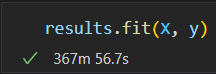

The best accuracy we could achieve with the time constraints within the classical machine learning approach was approximately 60%. This might be a more complex task than the typical traditional machine learning tasks. Thus, we will use a more complex model to attempt this task: Deep Learning with Convolutional Neural Networks.

<a id="convolutional-neural-network-approach-custom-architecture"></a>
# Convolutional Neural Network Approach: Custom Architecture

In this section, I attempt to create a convolutional neural network architecture from "scratch" (building layer-by-layer using the Tensorflow and Keras Libraries).

In [8]:
# After many adjustments, 84 x 84 pixels was the size I settled on to rescale the images to
IMAGE_HEIGHT = IMAGE_WIDTH = 84
batch_size = 32

In [9]:
# Create training, validation, and testing datasets
training_data = image_dataset_from_directory(directory=PARENT_DIRECTORY,
                                          validation_split=0.25,
                                          label_mode='int',
                                          subset='training',
                                          seed=42,
                                          image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                          batch_size=batch_size)

validation_data = image_dataset_from_directory(directory=PARENT_DIRECTORY,
                                          validation_split=0.25,
                                          label_mode='int',
                                          subset='validation',
                                          seed=42,
                                          image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                          batch_size=batch_size)


# Show number of batches in validation set pre-split
val_batches = validation_data.cardinality().numpy()
print(f'Number of validation batches pre-testing split: {val_batches}')

# Split validation set
test_data = validation_data.take((val_batches) // 5)
validation_data = validation_data.skip((val_batches) // 5)

# Show number of batches in testing set and validation set post-split
print(f'Number of batches witheld for testing data: {test_data.cardinality().numpy()}')
print(f'Number of validation batches post-testing split: {validation_data.cardinality().numpy()}')

Found 2394 files belonging to 6 classes.
Using 1796 files for training.
Found 2394 files belonging to 6 classes.
Using 598 files for validation.
Number of validation batches pre-testing split: 19
Number of batches witheld for testing data: 3
Number of validation batches post-testing split: 16


In [10]:
def configure_performant_datasets(dataset, shuffling=None):
    """
    Custom function to prefetch and cache stored elements
    of retrieved image data to boost latency and performance
    at the cost of higher memory usage.
    
    Code for this function taken from Flatiron resource
    """
    # Cache and prefetch elements of input data for boosted performance
    if not shuffling:
        return dataset.cache().prefetch(buffer_size=AUTOTUNE)
    else:
        return dataset.cache().shuffle(shuffling).prefetch(buffer_size=AUTOTUNE)
    
training_dataset = configure_performant_datasets(training_data,
                                                 shuffling=1796)
validation_dataset = configure_performant_datasets(validation_data)

testing_dataset = configure_performant_datasets(test_data)

In [11]:
# Alias the different layers that will be used
Conv2D = layers.Conv2D
MaxPool2D = layers.MaxPooling2D
Dropout = layers.Dropout
Flatten = layers.Flatten
Dense = layers.Dense
GaussianNoise = layers.GaussianNoise
Rescaling = layers.Rescaling
RandomFlip = layers.RandomFlip

In [12]:
# Create each individual layer
# These layers were finely tuned as much as possible within a reasonable amount of time within the time constraints

# Normalize the images
rescale = Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

# Add noise to the images
noise = GaussianNoise(0.1)

# 2 Convolutional Layers
conv_1 = Conv2D(16,
                kernel_size=(3,3),
                padding='valid',
                strides=(1,1),
                activation='relu',
                input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

conv_2 = Conv2D(35,
                kernel_size=(3,3),
                padding='valid',
                strides=(1,1),
                activation='relu')

# Max Pooling Layer
pooling_1 = MaxPool2D(pool_size=(2,2), strides=(1,1))

# Dropout for regularization
dropout_2 = Dropout(0.35)

# Flattening layer to pass into fully connected layers
flatten = Flatten()

# One fully connected dense layer and another dropout
fc_1 = Dense(25,
             activation='leaky_relu')
dropout_3 = Dropout(0.5)

# Output
output = Dense(6,
               activation = 'softmax')

c:\Users\twitt\anaconda3\envs\deep-learn-env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\twitt\anaconda3\envs\deep-learn-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# One extra augmentation layer
horizontal_flip = RandomFlip("horizontal",
                            input_shape=(IMAGE_HEIGHT,
                                         IMAGE_WIDTH,
                                         3))

In [14]:
# Create model and add layers in order that yielded the smallest loss and the greatest accuracy
model = Sequential()

model.add(horizontal_flip)
model.add(noise)
model.add(rescale)
model.add(conv_1)
model.add(conv_2)
model.add(pooling_1)
model.add(dropout_2)
model.add(flatten)
model.add(fc_1)
model.add(dropout_3)
model.add(output)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 84, 84, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 84, 84, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 84, 84, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 82, 82, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 35)     │         5,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 35)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 79, 79, 35)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 218435)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │     5,460,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,466,579 (20.85 MB)

 Trainable params: 5,466,579 (20.85 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Adam optimizer with an adjusted learning rate
optimizer = Adam(0.0001)

model.compile(optimizer=optimizer,
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# callback = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1)

epochs, batch_size = 20, 16

In [16]:
history = model.fit(training_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.1872 - loss: 2.0320 - val_accuracy: 0.3287 - val_loss: 1.6189
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.3461 - loss: 1.6145 - val_accuracy: 0.4283 - val_loss: 1.4767
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.4479 - loss: 1.4611 - val_accuracy: 0.4721 - val_loss: 1.3240
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.5106 - loss: 1.3354 - val_accuracy: 0.5398 - val_loss: 1.2843
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.5034 - loss: 1.2856 - val_accuracy: 0.5777 - val_loss: 1.1958
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.5177 - loss: 1.2742 - val_accuracy: 0.5677 - val_loss: 1.1400
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.5798 - loss: 1.1447 - val_accuracy: 0.6295 - val_loss: 1.1317
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.6078 - loss: 1.0795 - val_accuracy: 0

In [17]:
def plot_training_results(history):
    """
    Creates subplots that compare the training and validation losses and accuracies
    Returns nothing
    """
    # Get accuracy for training and validation sets
    accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Get loss for training and validation sets
    loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Get range of epochs to produce common plotting range
    epochs_range = range(1, epochs + 1)

    # Instantiate plotting figure space
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Create training/validation accuracy subplot
    axes[0].plot(epochs_range, accuracy, label='Training Accuracy')
    axes[0].plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    axes[0].legend(loc='lower right')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:,.0f}%'))
    axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')

    # Create training/validation loss subplot
    axes[1].plot(epochs_range, loss, label='Training Loss')
    axes[1].plot(epochs_range, validation_loss, label='Validation Loss')
    axes[1].legend(loc='upper right')
    axes[1].set_title('Training and Validation Loss')
    axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:,.1f}'))
    axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')

    # Render visualization
    plt.tight_layout()
    plt.show()

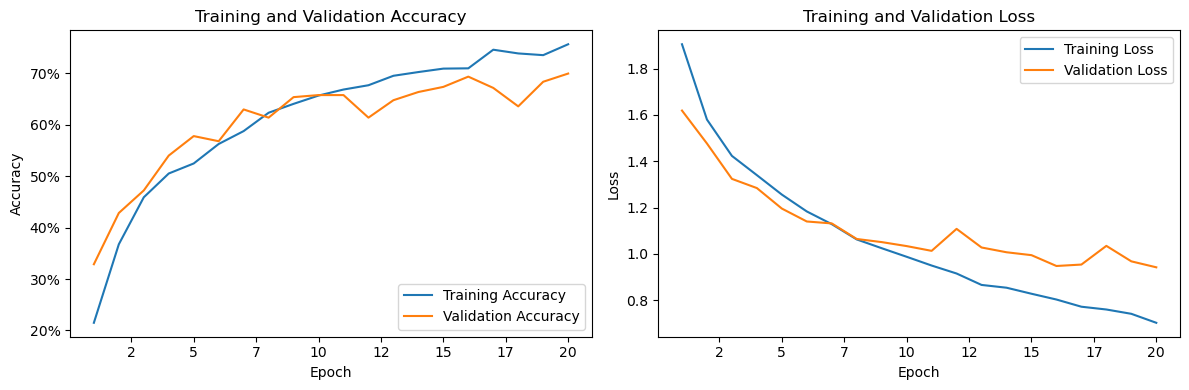

In [18]:
plot_training_results(history)

The model, as a whole, did not do the best and towards the latter epochs overfit to the training data. Granted, this is easier to do since this dataset is so small. However, using a neural network increased the predictive accuracy of the six classes by approximately 10% from the classical machine learning approach.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


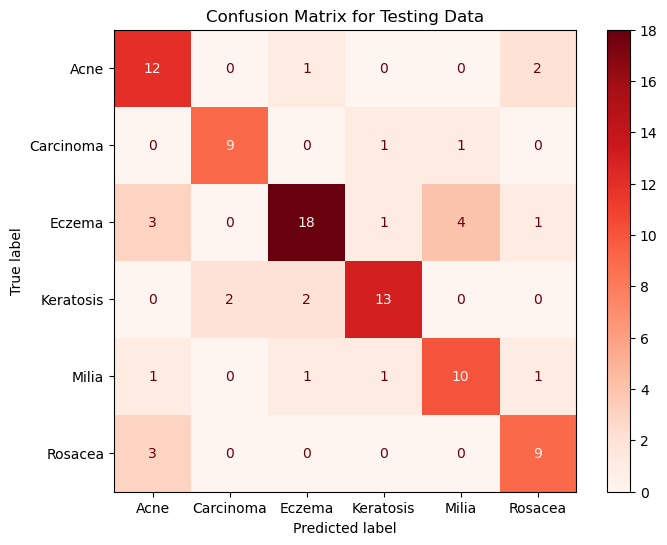

In [19]:
# Test the model for a final accuracy score and 
y_pred_prob = model.predict(testing_dataset)

y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.concatenate([y for x, y in testing_dataset], axis=0)


class_names = training_data.class_names

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, cmap='Reds')
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
ax.set_title("Confusion Matrix for Testing Data");

In [20]:
accuracy_score(y_true, y_pred)

0.7395833333333334

## Test with Custom Image

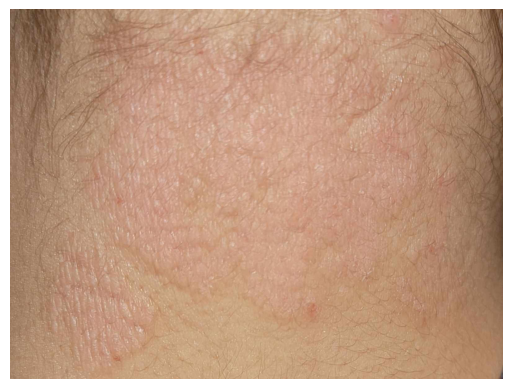

In [21]:
test_picture = cv2.imread("../test_skin_picture.jpg")
rgb = cv2.cvtColor(test_picture, cv2.COLOR_BGR2RGB)
plt.imshow(rgb, cmap=plt.cm.Spectral)
plt.axis('off');

In [35]:
image = np.resize(rgb, (IMAGE_HEIGHT, IMAGE_WIDTH, 3))  # Resize to match model input size 
image_data = np.array(image) / 255.0  # Normalize pixel values 
image_data = np.expand_dims(image_data, axis=0)

prediction_list = np.argmax(model.predict(image_data), axis=1)
prediction = class_names[prediction_list[0]]
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


'Rosacea'

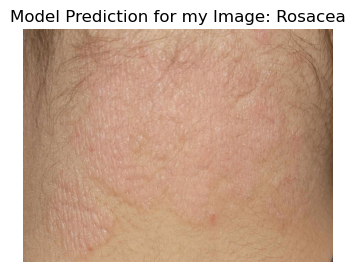

In [40]:
plt.figure(figsize=(4, 4))
plt.imshow(rgb)
plt.axis('off')
plt.title(f'Model Prediction for my Image: {prediction}');

<a id="summary-of-modeling-approaches"></a>
# Summary of Modeling Approaches


The final accuracy of the HOG transformed dataset fed into a Gradient Boosting Classifier was approximately 58-60%. The final testing accuracy of the architected convolutional neural network was approximately 73%. The CNN yielded about a 13-15% increase in performance from the Gradient Boosting Classifier.

<a id="external-resources"></a>
# External Resources
---
https://www.mayoclinic.org/diseases-conditions/rosacea/symptoms-causes/syc-20353815

https://www.aad.org/media/stats-numbers

https://selfdriving5.github.io/udacity/Self-Driving%20Car%20Engineer%20v5.0.0(us)/Part%2003-Module%2001-Lesson%2001_Object%20Detection/20.%20scikit-image%20HOG.html

https://machinelearningmastery.com/opencv_hog/

https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog

https://medium.com/swlh/histogram-of-oriented-gradients-hog-for-multiclass-image-classification-and-image-recommendation-cf0ea2caaae8

https://customers.pyimagesearch.com/lesson-sample-histogram-of-oriented-gradients-and-car-logo-recognition/

https://learnopencv.com/histogram-of-oriented-gradients/